# Anomalies collector - deepdive tutorial!

<a href="https://colab.research.google.com/github/netdata/community/blob/main/netdata-agent-api/netdata-pandas/anomalies_collector_deepdive.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will walk through, step by step, a worked example of how the [netdata anomalies collector](https://github.com/andrewm4894/netdata/tree/anomalies-collector/collectors/python.d.plugin/anomalies) works under the hood. 

**Note**: you can click the "Open in Colab" button above to open this notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) where you can just get going with it without having to set up python environments or any messy stuff like that. If the button does not work then just [click here](https://colab.research.google.com/github/netdata/community/blob/main/netdata-agent-api/netdata-pandas/anomalies_collector_deepdive.ipynb).

**Another Note**: If you are just reading through this notebook then it might be better to view it using nbviewer [here](https://nbviewer.jupyter.org/github/netdata/community/blob/main/netdata-agent-api/netdata-pandas/anomalies_collector_deepdive.ipynb) or colab [here](https://colab.research.google.com/github/netdata/community/blob/main/netdata-agent-api/netdata-pandas/anomalies_collector_deepdive.ipynb) as it will render a bit prettier than in Github.

In [1]:
# uncomment the below line to install required packages if needed (you will need to do this the first time if running in Google Colab).
#!pip install netdata-pandas==0.0.28 numba==0.50.1 scikit-learn==0.23.2 pyod==0.8.3

## Contents:
- [Overview](#Overview)
- [Inputs & configuration](#Inputs-&-configuration)
- [An aside on PCA](#An-aside-on-PCA)
- [Initialize our models](#Initialize-our-models)
- [Get training data](#Get-training-data)
- [Preprocess or "featurize" the training data](#Preprocess-or-"featurize"-the-training-data)
- [Train models](#Train-models)
- [Get pediction data](#Get-pediction-data)
- [Get predictions](#Get-predictions)
- [But what _is_ the model?](#But-what-is-the-model?)
- [Ok so lets step through that!](#Ok-so-lets-step-through-that!)

But first, lets start with a meme...

![image](img/mlfunny.jpg)

## Overview

There are three main concepts central to what the anomalies collector does:

- **Featurization**: This is how we take the raw data for each chart and preprocess it into a feature representation or "[feature vector](https://en.wikipedia.org/wiki/Feature_(machine_learning\))" used by the model. A simple way to think of this is that we just take each row of data and add some extra columns to encode some additional information. For example, a smoothed average of the last `lags_n` values for each dimension on the chart so the model can have some knowledge of the recent past beyond just the latest raw values of the dimensions.

- **Training**: A function to take our "featurized" training data and train our models, one for each chart (or [custom models](https://github.com/andrewm4894/netdata/tree/anomalies-collector/collectors/python.d.plugin/anomalies#custom-models) if you have defined any). This function will do slightly different things depending on what [model](https://pyod.readthedocs.io/en/latest/pyod.models.html#) you use. In a broad sense, its job is to train the model to form a useful, more compact, representation of the training data and then we can use this representation to measure our level of surprise at new data that we want to get anomaly scores for. So for the default PCA model this involves leveraging finding a lower dimensional representation that does a good job at reconstructing the main characteristics of the variance in our training data. Some other models might take a slightly different approach use different representations and algorithms to get to that "measure of surprise" for each feature vector. For the purpose of what we are doing this is largely abstracted away by the [API of the PyOD library](https://pyod.readthedocs.io/en/latest/pyod.html#api-reference), such that as a user we can easily switch between various models and still have broadly the same inputs ([Numpy arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html)) and outputs (also Numpy array's of anomaly scores, probabilities, and flags).

- **Prediction**: Each trained model has a [`predict()`](https://pyod.readthedocs.io/en/latest/api_cc.html#pyod.models.base.BaseDetector.predict) function that we can use by passing in a new feature vector and getting back an anomaly probability and anomaly flag from the trained model. This is the part where we actually use the trained model as new data arrives to ask - "how unusual does this new data look?"  

## Lets go!

In [2]:
import time
from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display, Markdown
from IPython.lib.display import YouTubeVideo
import numpy as np
import pandas as pd
from netdata_pandas.data import get_data, get_allmetrics
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest


def make_features(df, lags_n, diffs_n, smooth_n):
    """Given a pandas dataframe preprocess it to take differences, add smoothing, and lags as specified. 
    """
    if diffs_n >= 1:
        # take differences
        df = df.diff(diffs_n).dropna()
    if smooth_n >= 2:
        # apply a rolling average to smooth out the data a bit
        df = df.rolling(smooth_n).mean().dropna()
    if lags_n >= 1:
        # for each dimension add a new columns for each of lags_n lags of the differenced and smoothed values for that dimension
        df_columns_new = [f'{col}_lag{n}' for n in range(lags_n+1) for col in df.columns]
        df = pd.concat([df.shift(n) for n in range(lags_n + 1)], axis=1).dropna()
        df.columns = df_columns_new
    # sort columns to have lagged values next to each other for clarity when looking at the feature vectors
    df = df.reindex(sorted(df.columns), axis=1)
    
    return df


## Inputs & configuration

In the next cell we will define all the inputs we will use in this tutorial. Feel free to play with them once you are familiar with how it all hangs together.

Below you will see that the paramater values map to a subset of the inputs (the most important ones to help explain whats going on) required as part of the [`anomalies.conf`](https://github.com/andrewm4894/netdata/blob/anomalies-collector/collectors/python.d.plugin/anomalies/anomalies.conf) configuration for the [anomalies collector](https://github.com/andrewm4894/netdata/blob/anomalies-collector/collectors/python.d.plugin/anomalies) itself.

In [3]:
# inputs

# what host will we use
host = 'london.my-netdata.io'

# for this tutorial we will just use a few charts
charts_in_scope = ['system.cpu', 'system.load', 'system.net', 'system.io']

# what model from PyOD will we use under the hood
model = 'pca'

# how many seconds of data will we train our models on
train_n_secs = 14400

# what contamination rate will we use, see some discussion here to understand this one more: https://github.com/yzhao062/pyod/issues/144
contamination = 0.001

# if we want to ignore a recent window of data when training the model we can use this
offset_n_secs = 0

# how many lags to include in our feature vector
lags_n = 5

# how much smoothing to apply in our feature vector
smooth_n = 3

# if we want to do everything in terms of differences then we set diffs_n=1
diffs_n = 1

# for purpose of this turorial how many prediction steps will we take once we have a trained model
n_prediction_steps = 20

## An aside on PCA

By default the anomalies collector uses the `PCA` model, primarily this is because the PCA model gives a good combination of being able to capture and model flexible patterns in the data while also being computationally cheap since under the hood it is using the well researched, optimized and understood [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) algorithm to decompose our featurized data and project it onto a lower dimensional space. At a high level, when we see new data that is in a strange or unexpected part of this lower dimensional space then this is symptomatic of some anomalous data and so will get a higher anomaly score. 

- api: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.pca
- source: https://pyod.readthedocs.io/en/latest/_modules/pyod/models/pca.html

**Note**: If you want to learn more about PCA and play with some notebooks exploring PCA in a similar manner to this one then check out [this chapter](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) from the great [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook) by [Jake Vander Plas](https://twitter.com/jakevdp).

The image below (taken from the book) gives a good intuition about a way of thinking of PCA as (almost) dimensionality reduction. In the image below we are looking at how PCA could be used to "compress" the X and Y data into one single dimension of numbers by projecting each pair of points onto the corresponding solid blue line of dots. 

![image](img/pca1.png)

Or if a [Computerfile](https://www.youtube.com/channel/UC9-y-6csu5WGm29I7JiwpnA) video is more your thing then check out the below one as it does a better job then we can here.

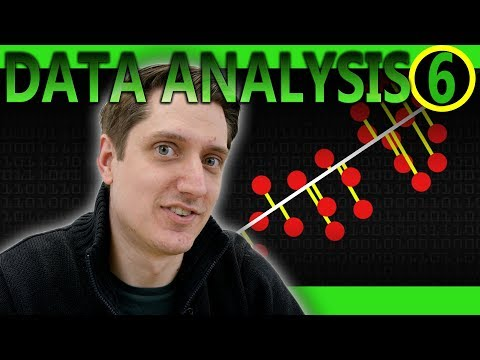

In [4]:
YouTubeVideo('TJdH6rPA-TI')

In this sense the PCA is learning a compressed representation of the data (technically, as mentioned in the video above, its a transformed representation in a different space, but we dont need to get too bogged down in that for our purposes here). This is essentially how PyOD uses PCA for anomaly detection under the hood. 

So we use PCA to learn a compressed representation of all the training data for each chart is some more abstract lower dimensional space that can be of use to us. The "of use to us" part here comes from the fact that PCA picks these lower dimensional representations in a clever way (using [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)) that maximises the amount of information about the main directions of variance of the original dataset. e.g. in the image above the line of blue dots is the best line we could project our data onto in order to maintain as much information as possible about the variance of the original 2 dimensional dataset, as you can see there is much more 'spread' in the data along the original x-axis than the y-axis and that is what is captured by the 'spread' in the solid blue line of dots.  

So when we see a new observation if it does not map well into this lower level representation we have learned during training, then that tells us that this new observation does not fit well into the representation we learned during training and as such it's probably somewhat anomalous, at least in comparison to what we observed in general in our training data. 

**Note**: We have looked at PCA a little bit above, but the point of awesome libraries like PyOD is that you don't really need to go that far down into the details - once you understand how the API works and a little bit about the various types of models/approaches used you can consider playing with and trying out other models on your data that take completely different approaches under the hood, for example:

- **hbos**: uses histograms as the underlying representations of your data used to then measure the surprise of new data ([more info](https://www.dfki.de/fileadmin/user_upload/import/6431_HBOS-poster.pdf)).
- **cblof**: somewhat similar in approach to pca but learned clusters as the representation of your training data and then it's the distance of new observations to the learned cluster centroids that is used to generate an anomaly score ([a good blog post](http://towardsdatascience.com/local-outlier-factor-for-anomaly-detection-cc0c770d2ebe)).
- **iforest**: uses a [isolation forest](https://en.wikipedia.org/wiki/Isolation_forest) as the underlying model and then observations that end up on strnage partso f that learned forest are then considered more anomalous ([sklearn user guide](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest)). 
- ...[etc](https://pyod.readthedocs.io/en/latest/pyod.models.html).

**Note**: Not all models from PyOD have been implemented in the anomalies collector as some turned out to be too expensive for the specific use case of unsupervised anomaly detection on your Netdata node itself (or even on a parent node). To that end, the models available in the collector are [`pca`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.pca), [`hbos`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.hbos), [`iforest`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest), [`cblof`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof), [`loda`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.loda), [`copod`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.copod) or [`feature_bagging`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.feature_bagging).


## Initialize our models

Now we will initialize a PyOD model for each chart in `charts_in_scope`. Each model type in PyOD will have various different input parameters that a user can play with, we will tend to use the defaults and override them sometimes with ones we have picked based on what we know about the task we are working on. Generally these model parameters, apart from `contamination`, are hardcoded into the anomalies collector based on our internal research as we developed the collector, you can see this in the [collector code here](https://github.com/andrewm4894/netdata/blob/anomalies-collector/collectors/python.d.plugin/anomalies/anomalies.chart.py#L77).

In the cell below we have added a comment for the source and API reference of each model from PyOD so you can take a look and read more about each one.

In [5]:
# initialize a model for each chart
if model == 'pca':
    # api: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.pca
    # source: https://pyod.readthedocs.io/en/latest/_modules/pyod/models/pca.html
    models = {c: PCA(contamination=contamination, n_components=2, n_selected_components=2) for c in charts_in_scope}
elif model == 'hbos':
    # api: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.hbos
    # source: https://pyod.readthedocs.io/en/latest/_modules/pyod/models/hbos.html
    models = {c: HBOS(contamination=contamination) for c in charts_in_scope}
elif model == 'cblof':
    # api: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof
    # source: https://pyod.readthedocs.io/en/latest/_modules/pyod/models/cblof.html
    models = {c: CBLOF(contamination=contamination, n_clusters=4) for c in charts_in_scope}
elif model == 'iforest':
    # api: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest
    # source: https://pyod.readthedocs.io/en/latest/_modules/pyod/models/iforest.html
    models = {c: IForest(contamination=contamination, n_estimators=50, bootstrap=True, behaviour='new') for c in charts_in_scope}
else:
    # we used the HBOS as default as it is both fast and robust to many different types of data and has proven in internal development 
    # to have less failure modes then some other models given the wide variaty of data we are expecting to be thrown at it
    models = {c: HBOS(contamination=contamination) for c in charts_in_scope}

## Get training data

The first thing we need to do is get our raw training data for each chart we want to build a model for.

To get the data we will make use of the [netdata-pandas](https://github.com/netdata/netdata-pandas) library we have built to make multiple asynchronous calls (using [asks](https://github.com/theelous3/asks) and [trio](https://github.com/python-trio/trio)) to the [Netdata REST API](https://learn.netdata.cloud/docs/agent/web/api) and basically wrangle the results into a nice [Pandas](https://pandas.pydata.org/) [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [6]:
# define the window for the training data to pull
before = int(datetime.now().timestamp()) - offset_n_secs
after =  before - train_n_secs

# get the training data
df_train = get_data(hosts=host, charts=charts_in_scope, after=after, before=before, sort_cols=True, numeric_only=True, float_size='float32')
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14400 entries, 1604322416 to 1604336815
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   system.cpu|guest       14400 non-null  float32
 1   system.cpu|guest_nice  14400 non-null  float32
 2   system.cpu|iowait      14400 non-null  float32
 3   system.cpu|irq         14400 non-null  float32
 4   system.cpu|nice        14400 non-null  float32
 5   system.cpu|softirq     14400 non-null  float32
 6   system.cpu|steal       14400 non-null  float32
 7   system.cpu|system      14400 non-null  float32
 8   system.cpu|user        14400 non-null  float32
 9   system.io|in           14400 non-null  float32
 10  system.io|out          14400 non-null  float32
 11  system.load|load1      14396 non-null  float32
 12  system.load|load15     14396 non-null  float32
 13  system.load|load5      14396 non-null  float32
 14  system.net|received    14400 non-null  f

,system.cpu|guest,system.cpu|guest_nice,system.cpu|iowait,system.cpu|irq,system.cpu|nice,system.cpu|softirq,system.cpu|steal,system.cpu|system,system.cpu|user,system.io|in,system.io|out,system.load|load1,system.load|load15,system.load|load5,system.net|received,system.net|sent
time_idx,,,,,,,,,,,,,,,,
1604322416,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.501253,0.501253,0.0,-29.596201,NaN,NaN,NaN,10.425649,-24.132299
1604322417,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.005025,0.753769,0.0,-14.403805,NaN,NaN,NaN,170.781296,-25.865431
1604322418,0.0,0.0,0.0,0.0,0.0,0.0,0.252525,0.252525,0.505050,0.0,0.000000,NaN,NaN,NaN,91.350983,-17.887140
1604322419,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250627,0.751880,0.0,0.000000,NaN,NaN,NaN,40.093201,-31.716980
1604322420,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.002506,0.250627,0.0,0.000000,0.07,0.03,0.07,58.252480,-48.352341


Above we can see our raw training data is just a pandas `DataFrame` with a timestamp index and a column of floats for each dimension from our `charts_in_scope` list.

**Note**: The [netdata-pandas](https://github.com/netdata/netdata-pandas) default naming convention for columns is "chart.name|dimension.name" 

## Preprocess or "featurize" the training data

Before we train our model we will first do some preprocessing to the raw data to create a "feature vector" to try and encode a more flexible and powerful representation for the model to work with as opposed to just looking at the most recently observed values in isolation. 

This is the "featurization" we mentioned at the begining of the notebook. The idea here is to give the model some extra information so that it may spot more complex and interesting anomalies as opposed to just spikes where one metric is a very high or very low value.   

In [7]:
# lets preprocess or "featurize" our raw data
df_train_processed = make_features(df_train, lags_n, diffs_n, smooth_n)

# print out the shape of our featurized data
print(df_train_processed.shape)
df_train_processed.head()

(14388, 96)


,system.cpu|guest_lag0,system.cpu|guest_lag1,system.cpu|guest_lag2,system.cpu|guest_lag3,system.cpu|guest_lag4,system.cpu|guest_lag5,system.cpu|guest_nice_lag0,system.cpu|guest_nice_lag1,system.cpu|guest_nice_lag2,system.cpu|guest_nice_lag3,...,system.net|received_lag2,system.net|received_lag3,system.net|received_lag4,system.net|received_lag5,system.net|sent_lag0,system.net|sent_lag1,system.net|sent_lag2,system.net|sent_lag3,system.net|sent_lag4,system.net|sent_lag5
time_idx,,,,,,,,,,,,,,,,,,,,,
1604322428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-48.354103,2.414706,18.004237,42.806609,-0.176394,-9.351936,4.649673,15.699247,22.307294,-34.915802
1604322429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.824290,-48.354103,2.414706,18.004237,40.087561,-0.176394,-9.351936,4.649673,15.699247,22.307294
1604322430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.151538,27.824290,-48.354103,2.414706,-43.871718,40.087561,-0.176394,-9.351936,4.649673,15.699247
1604322431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.983182,17.151538,27.824290,-48.354103,-36.622138,-43.871718,40.087561,-0.176394,-9.351936,4.649673
1604322432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-46.984114,-7.983182,17.151538,27.824290,-7.032575,-36.622138,-43.871718,40.087561,-0.176394,-9.351936


The below few cells will explore a little what we have just done to try and make the ideas of preprocessing aka "featurization" aka "feature vector" a little clearer.

Terms like "featurization" and "feature vector" are often used to sound fancy, but in reality its typically just as simple as adding additional columns to each row of your data where those new columns have numbers in them that represent something about your data that you want to make available to the model. 

So in our case adding lagged values of each smoothed and differenced dimension, is basically a design choice we make whereby we are telling the model we want it to consider `lags_n` recent values as opposed to just the latest observed dimensions. We do this because there are many [different types of anomalies](https://andrewm4894.com/2020/10/19/different-types-of-time-series-anomalies/) we want to try and be able to spot, so making a small snippet of recent data for each dimension available to the model gives us the ability to capture more complex anomaly patterns that might occur.

If we were to just train the model on the most recent values for each dimension the best we could reasonably hope for it to capture would be anomalies where one or more dimension takes an unusually high or low value for one time step. This is essentially not that much better then a traditional approach using [z-scores](https://towardsdatascience.com/z-score-for-anomaly-detection-d98b0006f510). (If you are interested in comparing the two we actually also have a [zscores collector](https://github.com/andrewm4894/netdata/tree/zscores-collector/collectors/python.d.plugin/zscores) too, if, for example, you would like to just start simple or cannot install the ML Python libraries the anomalies collector depends on). 

In [8]:
# Lets look at how the shape of our data has changed due to preprocessing
print(f'df_train shape is {df_train.shape}')
print(f'df_train_processed is {df_train_processed.shape}')
n_cols_added = len(df_train_processed.columns)-len(df_train.columns)
print(f'make_features has added {n_cols_added} new columns, one for each lags_n ({df_train.shape[1]}*{lags_n}={n_cols_added})')

df_train shape is (14400, 16)
df_train_processed is (14388, 96)
make_features has added 80 new columns, one for each lags_n (16*5=80)


So as you can see from the above output, our featurization has added a new column for each `lags_n` specified. And we have also lost a few rows due to `smooth_n` and `diffs_n`

To be super clear lets look at the first few rows of training data for a specific metric before and after preprocessing. 

**Note**: Look at the last `time_idx` to see how the featurization works for a specific timestamp of data.

In [9]:
metric = 'system.cpu|user'
print('raw data')
display(df_train[df_train.columns[df_train.columns.str.startswith(metric)]].head(3 + lags_n + smooth_n + diffs_n))

raw data


,system.cpu|user
time_idx,
1604322416,0.501253
1604322417,0.753769
1604322418,0.505050
1604322419,0.751880
1604322420,0.250627
1604322421,0.251889
1604322422,0.251889
1604322423,1.000000
1604322424,0.502513


In [10]:
print('featurized data')
display(df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(metric)]].head(1))

featurized data


,system.cpu|user_lag0,system.cpu|user_lag1,system.cpu|user_lag2,system.cpu|user_lag3,system.cpu|user_lag4,system.cpu|user_lag5
time_idx,,,,,,
1604322428,-0.166249,0.168348,-0.080808,0.24937,0.083541,0.249791


In [11]:
print('manualy calculated')
df_manual_example = df_train[df_train.columns[df_train.columns.str.startswith(metric)]].copy()
# take diff
df_manual_example['diff'] = df_manual_example[metric].diff(diffs_n)
# apply smoothing
df_manual_example['smoothed'] = df_manual_example['diff'].rolling(smooth_n).mean()
display(df_manual_example.head(3 + lags_n + smooth_n + diffs_n).tail(1 + smooth_n + diffs_n))

manualy calculated


,system.cpu|user,diff,smoothed
time_idx,,,
1604322423,1.000000,0.748111,0.249791
1604322424,0.502513,-0.497487,0.083541
1604322425,1.000000,0.497487,0.249370
1604322426,0.757576,-0.242424,-0.080808
1604322427,1.007557,0.249981,0.168348


Above you can see how one raw metric value is now being preprocessed to be a vector of `lags_n` differenced and smoothed values. It is this matrix of smoothed differences that the model will use for both training and when making predictions. 

So, for example, if a chart has 2 dimensions and we have set `lags_n` to be 5 then our featurized 'matrix' of numbers will be a 2*(1+5) matrix. In reality this matrix is just flattened into a feature vector of 2 * (1+5) = 12 floating point values. The cell below shows this for the `system.net` chart as that is an example with 2 dimensions. 

In [12]:
# lets look at our first feature vector for the 'system.net' model 
chart = 'system.net'
print(df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(chart)]].head(1).shape)
print(df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(chart)]].head(1).values)

(1, 12)
[[ 17.15153758  27.82428996 -48.35410309   2.41470591  18.00423749
   42.80660947  -0.17639414  -9.35193634   4.64967346  15.69924672
   22.30729421 -34.915802  ]]


## Train models

Now that we have our preprocessed training data we will train a model for each chart using our featurized data that represents each time step for each chart as a differenced, smoothed, and lagged matrix for each chart.

In [13]:
# loop over each chart in scope and train a model for each
for chart in charts_in_scope:
    # pull out the columns relating to the chart based on what thier name startswith and put it into a numpy array of values
    X_train = df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(chart)]].values
    print(f'train model for {chart} using X_train of {X_train.shape}')
    # call the fit() method on each initialized model and pass it the full numpy array of our featurized training data
    models[chart] = models[chart].fit(X_train)

train model for system.cpu using X_train of (14388, 54)
train model for system.load using X_train of (14388, 18)
train model for system.net using X_train of (14388, 12)
train model for system.io using X_train of (14388, 12)


So we have now trained our models, one for each chart based on our preprocessed training data. To be concrete we will look at some example obvervations our model has been trained on. 

In [14]:
# lets look at the first matrix or "feature vector" for our first model
obs_n = 0
model_n = 0
print(f'timestamp={df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(charts_in_scope[model_n])]].index[obs_n]}')
print(f'feature vector for {obs_n}th training observation for {charts_in_scope[model_n]} model:')
print(df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(charts_in_scope[model_n])]].values[obs_n]) 

timestamp=1604322428
feature vector for 0th training observation for system.cpu model:
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.08333333  0.          0.         -0.00062973  0.          0.
  0.          0.          0.          0.         -0.08396307  0.
  0.0839599   0.16813707  0.17087543  0.0827036  -0.084174   -0.08416875
 -0.16624896  0.16834803 -0.08080806  0.24937026  0.08354112  0.24979113]


In [15]:
# and the next one
obs_n = 1
model_n = 0
print(f'timestamp={df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(charts_in_scope[model_n])]].index[obs_n]}')
print(f'feature vector for {obs_n}th training observation for {charts_in_scope[model_n]} model:')
print(df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(charts_in_scope[model_n])]].values[obs_n]) 

timestamp=1604322429
feature vector for 1th training observation for system.cpu model:
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.08333333  0.          0.         -0.00062973  0.
  0.          0.          0.          0.          0.         -0.08396307
 -0.33733324  0.0839599   0.16813707  0.17087543  0.0827036  -0.084174
 -0.00189871 -0.16624896  0.16834803 -0.08080806  0.24937026  0.08354112]


If you look close enough at the above two cells you will see the same values be shifted for each lag.

Each matrix of numbers above _is_ the representation we give to our model of each time step. This is how the model views each chart - a matrix ("feature vector" to sound fancy) of floating point numbers encoding some differenced and smoothed information about the last `lags_n` observations for each dimension in the specific chart we are modeling. 

**Note**: Within the anomalies collector, at some regular interval, as defined by `train_every_n` in the `anomalies.conf` file, we will repeat the above training step to retrain all models on the most recent window of available training data. 

#### Vistualize Training Data & Training Anomaly Scores

Now that we have covered what our feature vectors look like and trained our model. Lets see if we can visualize things a little to help our intuition of whats going on. 

To do this we will use our trained model to get back an anomaly score for each of our training observations. 

Then we will visualize a random sample of training data alongside the most highly scored training data (i.e most 'anomalous') and we should expect to see stark differences. 

In [16]:
# lets pick a chart/model to look at
chart = 'system.cpu'

# pick a number of random samples to look at
n_sample_random = 40
# look also at the top n most anomalously scored training data
n_high_score = 20

# get all the training data for that model
X_train = df_train_processed[df_train_processed.columns[df_train_processed.columns.str.startswith(chart)]].values
n_features = X_train.shape[1]

# score all our training data using the decision_function() method of the trained model - this will give use the raw internal anomaly score of the trained model
X_train_scores = models[chart].decision_function(X_train)

# determine some useful indices we can use to pull out the data we want
idx_random = np.random.randint(n_sample_random, size=n_sample_random)
idx_high = np.argpartition(X_train_scores, -n_high_score)[-n_high_score:]
idx = idx_random.tolist() + idx_high.tolist()

print(X_train.shape)
print(X_train_scores.shape)

X_train_random = X_train[idx_random,:]
print(X_train_random.shape)

X_train_high = X_train[idx_high,:]
print(X_train_high.shape)

X_train_examples = X_train[idx,:]
print(X_train_examples.shape)

(14388, 54)
(14388,)
(40, 54)
(20, 54)
(60, 54)


First we will just plot the random sample of our feature vectors as a line for each observation. 

**Note**: The x-axis here does not really mean much, it will just be the most recent and last lags_n values for each dimension on the chart. So this line plot if just a way to visualize the raw data for comparing observations. 

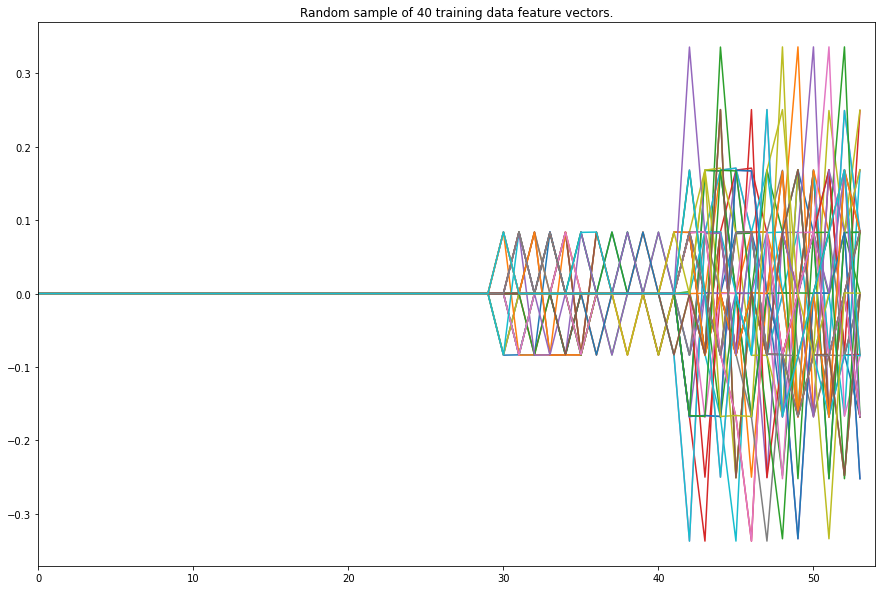

In [17]:
x_axis = np.array([n for n in range(0, n_features)])
plt.figure(figsize=(15,10))
p1 = plt.plot(x_axis, X_train_random.T)
plt.xlim(0, n_features)
plt.title(f'Random sample of {n_sample_random} training data feature vectors.')
plt.show()

Now lets plot the same plot as above, _**but**_ also include the feature vectors of the training observations that had this highest anomaly scores. 

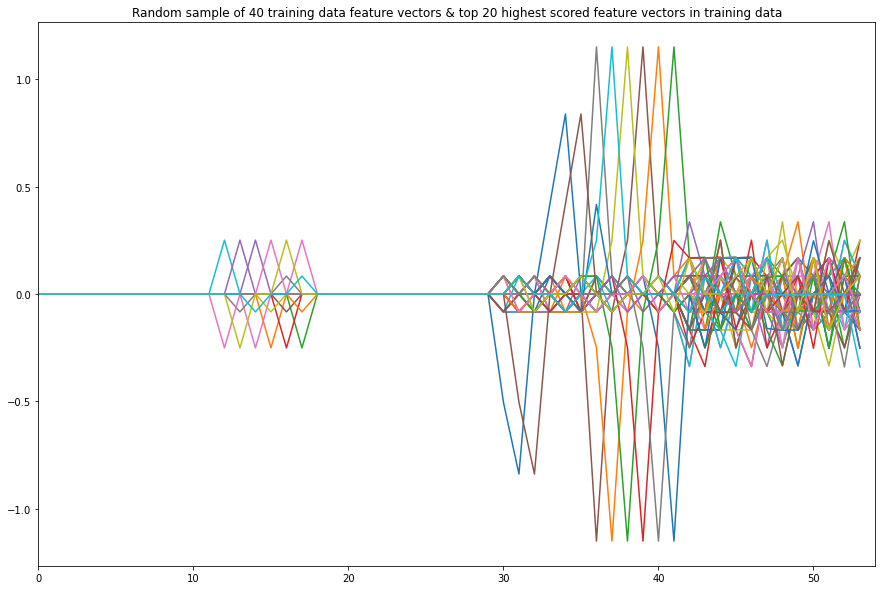

In [18]:
plt.figure(figsize=(15,10))
p1 = plt.plot(x_axis, X_train_examples.T)
plt.xlim(0, n_features)
plt.title(f'Random sample of {n_sample_random} training data feature vectors & top {n_high_score} highest scored feature vectors in training data')
plt.show()

Now in the above plot we can see that the highest scored feature vectors or 'line' that we added in seem to stand out and look much 'different' to how the plot did before.

**Note**: Don't forget to look at how the y-axis is also very different between the two plots.

Another way to show this is via a heatmap of our random training data stacked alongside our highly anomalous training data. SO the data above the line in the plot below is our random sample of observations while that below is our highly scored training data. 

You should be able to see a clear difference, even if its not very interpretable to us what the differences in numbers actually represents visually in terms of how it might look in the normal Netdata dashboard - we left that world behind a couple of cells back and are now looking at things in terms of how the model see's our data.

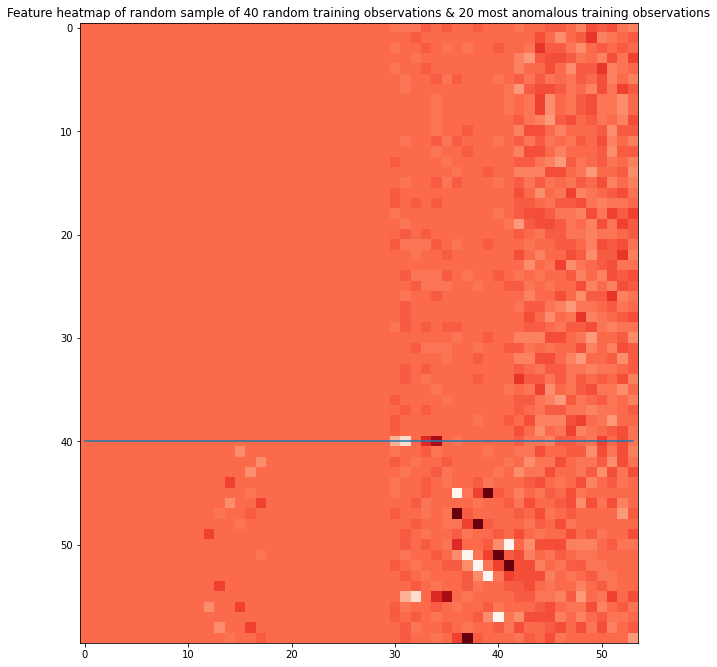

In [19]:
fig, ax = plt.subplots(figsize=(10, 16))
ax.imshow(X_train_examples, interpolation='nearest', cmap='Reds')
plt.title(f'Feature heatmap of random sample of {n_sample_random} random training observations & {n_high_score} most anomalous training observations')
plt.plot([n_sample_random for n in range(1,n_features+1)])
plt.show()

## Get pediction data

Now that we have our trained models for each chart we can use them in looking at incoming observations and 'ask' the trained models how 'unusual' it thinks they are. 

In [20]:
# define an empty dataframe we can store enough recent data into to generate our feature vector's for recent data on
df_recent = pd.DataFrame()

# simulate n_prediction_steps of getting latest data, making feature vecotr and getting predicitons
for prediction_step in range(n_prediction_steps):
    time.sleep(1) # sleep for a second to ensure getting a new timestamp from the host
    df_latest = get_allmetrics(host=host, charts=charts_in_scope, wide=True)[df_train.columns]
    df_latest['time_idx'] = int(time.time())
    df_latest = df_latest.set_index('time_idx')
    # just keep enough recent data to generate each feature vector
    df_recent = df_recent.append(df_latest).tail((lags_n + smooth_n + diffs_n) * 2)
    
    # now lets featurize our recent data to be able to get predictions from the model for each observation
    df_predict_processed = make_features(df_recent, lags_n, diffs_n, smooth_n)

print(f'we now have {df_predict_processed.shape[0]} recent preprocessed feature vectors to predict on.')

we now have 10 recent preprocessed feature vectors to predict on.


In [21]:
print(df_predict_processed.shape)
df_predict_processed.head()

(10, 96)


,system.cpu|guest_lag0,system.cpu|guest_lag1,system.cpu|guest_lag2,system.cpu|guest_lag3,system.cpu|guest_lag4,system.cpu|guest_lag5,system.cpu|guest_nice_lag0,system.cpu|guest_nice_lag1,system.cpu|guest_nice_lag2,system.cpu|guest_nice_lag3,...,system.net|received_lag2,system.net|received_lag3,system.net|received_lag4,system.net|received_lag5,system.net|sent_lag0,system.net|sent_lag1,system.net|sent_lag2,system.net|sent_lag3,system.net|sent_lag4,system.net|sent_lag5
time_idx,,,,,,,,,,,,,,,,,,,,,
1604336830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.489395,16.610539,-52.631793,16.882063,-22.258967,-9.932675,22.092011,30.948201,-15.380940,-35.036100
1604336832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.560585,15.489395,16.610539,-52.631793,-31.429321,-22.258967,-9.932675,22.092011,30.948201,-15.380940
1604336833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-32.245400,7.560585,15.489395,16.610539,-1.504474,-31.429321,-22.258967,-9.932675,22.092011,30.948201
1604336834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.613011,-32.245400,7.560585,15.489395,-63.304188,-1.504474,-31.429321,-22.258967,-9.932675,22.092011
1604336835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.543925,-4.613011,-32.245400,7.560585,-34.442787,-63.304188,-1.504474,-31.429321,-22.258967,-9.932675


The above featurized prediction data should be identical in terms of structure and schema to the featurized training data we explored above. This is what is expected by the model.  

## Get predictions

In [22]:
# for each recent feature vector, get a prediction
for time_idx, row in df_predict_processed.iterrows():
    
    print('-'*100)
    print(f'predictions for time {time_idx}')
    
    # convert our row into the expected 'flattened' feature vector
    df_tmp = row.to_frame().transpose()
    
    for model in models:
        
        # pull out relevant array of features for the model in question
        X_predict = df_tmp[df_tmp.columns[df_tmp.columns.str.startswith(model)]].values
        
        # call the predict_proba() and predict() methods on the trained data in order to make a prediction
        anomaly_probability = round(models[model].predict_proba(X_predict)[-1][1],4)
        anomaly_flag = models[model].predict(X_predict)[-1]
        
        print(f'model={model}, anomaly_probability={anomaly_probability}, anomaly_flag={anomaly_flag}')


----------------------------------------------------------------------------------------------------
predictions for time 1604336830
model=system.cpu, anomaly_probability=0.0449, anomaly_flag=0
model=system.load, anomaly_probability=0.0003, anomaly_flag=0
model=system.net, anomaly_probability=0.0123, anomaly_flag=0
model=system.io, anomaly_probability=0.0121, anomaly_flag=0
----------------------------------------------------------------------------------------------------
predictions for time 1604336832
model=system.cpu, anomaly_probability=0.0501, anomaly_flag=0
model=system.load, anomaly_probability=0.0003, anomaly_flag=0
model=system.net, anomaly_probability=0.0089, anomaly_flag=0
model=system.io, anomaly_probability=0.0137, anomaly_flag=0
----------------------------------------------------------------------------------------------------
predictions for time 1604336833
model=system.cpu, anomaly_probability=0.0575, anomaly_flag=0
model=system.load, anomaly_probability=0.0003, anoma

In the above we should generally see low `anomaly_probability` values (assuming nothing has blown up on the host you used between the time you ran the training cells above and the predictions above). 

Lets just do one last little thing to try show what is going on here and why we put so much effort and focus into the featurization above.

We will take one of the last feature vectors we predicted on for each model, randomly shuffle the values around so as to make an unusual looking observation, and see what sort of an anomaly probability that gives us. (hint: it should be higher then those above :) ).

In [23]:
# take last row from prediction data, shuffle the columns around
df_predict_shuffled = df_predict_processed.tail(1).transpose().sample(frac=1).transpose()
# ensure has same column names as expected by the models
df_predict_shuffled.columns = df_predict_processed.columns # rename things to really shuffle things
for model in models:
    X_predict = df_predict_shuffled[df_predict_shuffled.columns[df_predict_shuffled.columns.str.startswith(model)]].values
    anomaly_probability = round(models[model].predict_proba(X_predict)[-1][1],4)
    anomaly_flag = models[model].predict(X_predict)[-1]
    print(f'model={model}, anomaly_probability={anomaly_probability}, anomaly_flag={anomaly_flag}')

model=system.cpu, anomaly_probability=1.0, anomaly_flag=1
model=system.load, anomaly_probability=1.0, anomaly_flag=1
model=system.net, anomaly_probability=0.0055, anomaly_flag=0
model=system.io, anomaly_probability=0.3048, anomaly_flag=0


We _should_ see some higher anomaly probabilities above than in the predictions we had previously made. 

## But what _is_ the model?

To try and lift the lid a little on what the model actually is and how it is calculating anomaly probabilities lets take a look at one trained model and what it actually is. 

In [24]:
# lets pick our first trained model
model_to_explore = charts_in_scope[0]

print(f'model for chart {model_to_explore}:')
models[model_to_explore].__dict__

model for chart system.cpu:


{'contamination': 0.001,
 'n_components': 2,
 'n_selected_components': 2,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'weighted': True,
 'standardization': True,
 '_classes': 2,
 'scaler_': StandardScaler(),
 'detector_': PCA(n_components=2),
 'n_components_': 2,
 'components_': array([[-1.88207641e-17,  8.97013881e-18, -5.98534991e-18,
          2.16917600e-17,  5.35232405e-18,  3.73108538e-18,
         -4.29603230e-19,  1.17302312e-18,  2.77336076e-18,
          7.49626496e-19, -9.59122722e-19,  0.00000000e+00,
          7.76834978e-03,  1.55032677e-02, -1.30650414e-02,
         -1.45082849e-02, -2.01971151e-02,  1.08274794e-02,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.34862303e-01, -6.95948285e-03,  1

So above we see the various objects, mostly array's of numbers, that make up the internal state of the trained model. 

**Note**: for different types of models you will see different things in here. The below cells all assume `model='pca'` to walk through the example of how the default PCA model calculates an anomaly probability. Also for simplicity when we initialized the PCA model we set `n_selected_components=2` to make the calculations below easier to follow by telling PyOD to just use the first 2 principle components when calculating the anomaly scores. In the actual anomalies collector we use all the principle components.

For PCA the main things of relevance below will be: 

- `selected_components_`: The actual principle components we want to use when calculating the anomaly score (aka `decision_score`).
- `selected_w_components_`: The weights applied to each selected component, the first few typically matter more as they capture most of the variance in the original training data. 
- `decision_scores_`: The raw anomaly scores on all of the training observations, used to convert the anomaly score into something that more looks like an anomaly probability. 

#### Lets look at the 'training' source code

Lets look at what the PCA model does when it trains a model. W can see from the below that most of what is going on is fitting a [PCA from Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to the training data `X`

In [25]:
PCA.fit??

Signature: PCA.fit(self, X, y=None)
Source:   
    def fit(self, X, y=None):
        """Fit detector. y is ignored in unsupervised methods.

        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input samples.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        self : object
            Fitted estimator.
        """
        # validate inputs X and y (optional)
        X = check_array(X)
        self._set_n_classes(y)

        # PCA is recommended to use on the standardized data (zero mean and
        # unit variance).
        if self.standardization:
            X, self.scaler_ = standardizer(X, keep_scalar=True)

        self.detector_ = sklearn_PCA(n_components=self.n_components,
                                     copy=self.copy,
                                     whiten=self.whiten,
                                     svd_solver=self.svd_solver,
  

#### Lets look at the 'prediction' source code

Lets look at the source code for generating the anomaly probabilities.

In [26]:
PCA.predict_proba??

Signature: PCA.predict_proba(self, X, method='linear')
Source:   
    def predict_proba(self, X, method='linear'):
        """Predict the probability of a sample being outlier. Two approaches
        are possible:

        1. simply use Min-max conversion to linearly transform the outlier
           scores into the range of [0,1]. The model must be
           fitted first.
        2. use unifying scores, see :cite:`kriegel2011interpreting`.

        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input samples.

        method : str, optional (default='linear')
            probability conversion method. It must be one of
            'linear' or 'unify'.

        Returns
        -------
        outlier_probability : numpy array of shape (n_samples,)
            For each observation, tells whether or not
            it should be considered as an outlier according to the
            fitted model. Return the outlier probability, rangin

We can see its getting scores from some `decision_function()` method, so lets look at that.

In [27]:
PCA.decision_function??

Signature: PCA.decision_function(self, X)
Source:   
    def decision_function(self, X):
        """Predict raw anomaly score of X using the fitted detector.

        The anomaly score of an input sample is computed based on different
        detector algorithms. For consistency, outliers are assigned with
        larger anomaly scores.

        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only
            if they are supported by the base estimator.

        Returns
        -------
        anomaly_scores : numpy array of shape (n_samples,)
            The anomaly score of the input samples.
        """
        check_is_fitted(self, ['components_', 'w_components_'])

        X = check_array(X)
        if self.standardization:
            X = self.scaler_.transform(X)

        return np.sum(
            cdist(X, self.selected_components_) / self.selected_w_components_,
        

We can see here what actually look like relativley straightforward calculations, so lets try step through them below. 

## Ok so lets step through that!

So the cells above show the PyOD code under the hood - lets step through and recreate the a predicted score, step by step.

Lets begin by getting our feature vector that we would like an anomaly probability for.

In [28]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

# get our feature vector for a random observation from our prediction data
X = df_predict_processed[df_predict_processed.columns[df_predict_processed.columns.str.startswith(model_to_explore)]].sample(1).values

print('feature vector')
print(X.shape)
print(X)

feature vector
(1, 54)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  8.39630667e-02
   0.00000000e+00 -8.39630667e-02 -8.33333333e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.66666667e-01 -1.85037171e-17
   1.68562200e-01  0.00000000e+00 -8.20739000e-02 -2.51889167e-01
   2.48316500e-01 -8.39630667e-02  6.36100000e-04 -8.35390000e-02
   8.52225000e-02  8.39630667e-02]]


Lets look at the principle components the model will use to calculate our anomaly score.

In [29]:
print('selected components learned by model')
selected_components = models[model_to_explore].selected_components_
print(selected_components.shape)
print(selected_components)

selected components learned by model
(2, 54)
[[-1.88207641e-17  8.97013881e-18 -5.98534991e-18  2.16917600e-17
   5.35232405e-18  3.73108538e-18 -4.29603230e-19  1.17302312e-18
   2.77336076e-18  7.49626496e-19 -9.59122722e-19  0.00000000e+00
   7.76834978e-03  1.55032677e-02 -1.30650414e-02 -1.45082849e-02
  -2.01971151e-02  1.08274794e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.34862303e-01 -6.95948285e-03
   1.32904923e-01  1.32600765e-01 -2.80129491e-03 -1.33819320e-01
  -1.58499441e-01 -8.66179692e-03  1.45408906e-01  1.63338345e-01
   3.19900664e-03 -1.38127261e-01 -2.91627719e-01 -7.70165648e-02
   2.61343608e-01  2.90175331e-01  3.71454617e-02 -2.97633584e-01
  -3.82579616e-01 -1.22088354e-02  3.33422956e-01  3.19016618e-01
  -5.81946671e-02 -3.72818429e-01]
 [ 4.62288496e-17  1.49395849e-17 -4.20549409e-18  4.20051635e

Lets look at the weighting that the model will apply to each component when working out a weighted distance that will form the score.

In [30]:
print('selected components weights set by model')
selected_w_components = models[model_to_explore].selected_w_components_
print(selected_w_components.shape)
print(selected_w_components)

selected components weights set by model
(2,)
[0.06994716 0.06483917]


Lets just call `predict_proba(X)` to get the score we will try to recreate.

In [31]:
print('anomaly probability [p(anomaly), p(not anomaly)]')
anomaly_probability = models[model_to_explore].predict_proba(X)
print(anomaly_probability.shape)
print(anomaly_probability)

anomaly probability [p(anomaly), p(not anomaly)]
(1, 2)
[[0.93092766 0.06907234]]


#### Step 1: Standardize the feature vector

The first step is to standardize the data as this is a default common practice when fitting a PCA to data. 

This is the default here which is good as it means that if you define any [custom models](https://github.com/andrewm4894/netdata/tree/anomalies-collector/collectors/python.d.plugin/anomalies#custom-models) in your `anomalies.conf` file, you dont need to worry about them not being on the same or similar scales (e.g. cpu % vs disk usage etc) as that is all taken care of internally by the PyOD model. 

In [32]:
X_scaled = models[model_to_explore].scaler_.transform(X)
print(X_scaled)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -9.01258777e-20 -1.80251755e-19  0.00000000e+00
  -9.01258777e-20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.01304575e-04  1.46868557e+00
   1.01304575e-04 -1.46869192e+00 -1.45767655e+00  7.65630491e-07
  -2.23612411e-10 -2.23612411e-10 -2.23612411e-10 -2.23612411e-10
   1.57469336e-04  1.57469336e-04  1.33229753e+00  4.60616781e-05
   1.34712891e+00 -4.74603807e-05 -6.55993383e-01 -2.01323170e+00
   1.76111188e+00 -5.95226846e-01  4.71460358e-03 -5.92278839e-01
   6.04248600e-01  5.95077610e-01]]


#### Step 2: Calculate distance from each selected component 

Now we want to work out the distance of our feature vector to each of the selected components. 

This is the core part of what is going on when calculating an anomaly score using this model. 

If we have a strange feature vector then its going to be something we have not really seen before and so will not fit well into the lower dimensional representation learned by the PCA model. Hence it will have a somewhat larger distance from the selected principle components.

In [33]:
distance = cdist(X_scaled, selected_components)
print(distance.shape)
print(distance)

(1, 2)
[[4.64595334 4.7838691 ]]


**Note**: These distance numbers are just numbers, where bigger means more distant, but on their own are hard to interpret it terms of what they mean. So the next step will be to try and go from the weighted distance score to an anomaly probability by comparing the anomay score with all those we saw within the training data. It's the training data that will be our yardstick for trying to say just how anomalous a new observation is. 

#### Step 3: Use a weighted average distance as the anomaly score

We will take a weighted average of the distances, where the weights for each component will, by default, be related to the amount of variance in the original training data that each component 'explained' or represented (we can see this in the PyOD code [here](https://github.com/yzhao062/pyod/blob/master/pyod/models/pca.py#L252)).

In [34]:
print('anomaly score')
anomaly_score = np.sum(distance / selected_w_components, axis=1).ravel()
print(anomaly_score)

anomaly score
[140.20145072]


#### Step 4: Convert anomaly score into anomaly probabilities based on the anomaly scores of the training data

Now we will use the decision scores we calculated from basically running the prediction process back over the training data when we originally fit our model. 

We will use the distribution of scores in the training data to try and re-scale our raw anomaly score to look more like something that can pass as a probability.

**Note**: Strictly speaking this "anomaly probability" is not really a "real" probability in the sense of being some sort of more formal or theoretical output from some probabilistic process we have statistically modeled directly. Rather, its just a sensible re-scaling of our raw score based on what we saw in the training data. So a high 'probability' here really just means an unusual value in reference to the training data.

In [35]:
# get the raw anomaly scores from the training data
train_anomaly_scores = models[model_to_explore].decision_scores_

# create empty array for probabilities to go into
anomaly_probability_manual_calc = np.zeros([X.shape[0], int(models[model_to_explore]._classes)])

# create a scaler to rescale raw anomaly score to look more like a probability and be on the 0, 1 range
scaler = MinMaxScaler().fit(train_anomaly_scores.reshape(-1, 1))

# transform anomaly score into a probability by rescaling it based on the training data and clipping at 1
anomaly_probability_manual_calc[:, 1] = scaler.transform(anomaly_score.reshape(-1, 1)).ravel().clip(0, 1)

# use 1 - p(anomaly) as p(not anomaly)
anomaly_probability_manual_calc[:, 0] = 1 - anomaly_probability_manual_calc[:, 1]

print(anomaly_probability_manual_calc)

[[0.93092766 0.06907234]]


#### Do they match?

In [36]:
# do they match?
print(anomaly_probability)
print(anomaly_probability_manual_calc)
print(anomaly_probability == anomaly_probability_manual_calc)
assert np.sum(anomaly_probability == anomaly_probability_manual_calc) == 2

[[0.93092766 0.06907234]]
[[0.93092766 0.06907234]]
[[ True  True]]


....phew, thats it! Go get yourself a coffee :)